In [ ]:
'''
In this file, I did:
1. Used the pickle extracted from Stock_Plotting_v1_(Demo).ipydb for stock data and backtest Stratey
2. Test all sp500 stocks with one defined Trading Strategy (eg. but when price > ma , sell when price < ma )


'''

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import backtrader as bt
import datetime  # For datetime objects
import pickle
from scipy.stats import norm

In [22]:
# Create a Stratey // Buy Executed in another day morning open price
class TestStrategy(bt.Strategy):

    params = (
        ('maperiod', 15), # moving average period 
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
#         print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

        
    #Kobe: Here we implement the trading Strategy logic
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    profit = []
    for stock in sp500_ticker_list:
        try:
            cerebro = bt.Cerebro()

            # Create a Data Feed
            df = pd.read_pickle("sp500_stocks/{0}_av.pickle".format(stock))
            df.index = pd.to_datetime(df.index)
            #df column need to rename to fit the backtrader data detection of columns
            df.rename(columns={ '1. open':'open',
                            '2. high':'high',
                            '3. low':'low',
                            '4. close':'close',
                            '5. adjusted close':'adjusted close',
                            '6. volume':'volume',
                            '7. dividend amount':'dividend amount',
                            '8. split coefficient':'split coefficient'}, 
                         inplace=True)
            data = bt.feeds.PandasData(dataname=df, openinterest=None)

            # Add strategy using class TestStrategy(bt.Strategy)
            cerebro.addstrategy(TestStrategy)

            # Add the Data Feed to Cerebro
            cerebro.adddata(data)

            # Set the initial cash for portfolio
            cerebro.broker.setcash(100000.0)

            # Set the commission - 0.1% ... divide by 100 to remove the %
            cerebro.broker.setcommission(commission=0.001)

            # Add a FixedSize sizer according to the stake
            cerebro.addsizer(bt.sizers.FixedSize, stake=10)


            print('Starting Portfolio Value of {}: {}'.format(stock, cerebro.broker.getvalue()) )

            cerebro.run()

            print('Final Portfolio Valueof {}: {}'.format(stock, cerebro.broker.getvalue()) )

            profit.append(cerebro.broker.getvalue())
        except:
            print("An exception occurred at {}".format(stock)) 
    
    

Starting Portfolio Value of MMM: 100000.0
Final Portfolio Valueof MMM: 98710.72866099993
Starting Portfolio Value of ABT: 100000.0
Final Portfolio Valueof ABT: 99184.4015009997
Starting Portfolio Value of ABBV: 100000.0
Final Portfolio Valueof ABBV: 100046.82780000013
Starting Portfolio Value of ABMD: 100000.0
Final Portfolio Valueof ABMD: 100819.44801999988
Starting Portfolio Value of ACN: 100000.0
Final Portfolio Valueof ACN: 99804.81911999999
Starting Portfolio Value of ATVI: 100000.0
Final Portfolio Valueof ATVI: 99833.8256220001
Starting Portfolio Value of ADBE: 100000.0
Final Portfolio Valueof ADBE: 99510.32508299996
Starting Portfolio Value of AMD: 100000.0
Final Portfolio Valueof AMD: 99846.41829999984
Starting Portfolio Value of AAP: 100000.0
Final Portfolio Valueof AAP: 99957.10331399985
Starting Portfolio Value of AES: 100000.0
Final Portfolio Valueof AES: 99617.99040000008
Starting Portfolio Value of AMG: 100000.0
Final Portfolio Valueof AMG: 99172.6362999999
Starting Portf

Final Portfolio Valueof CAT: 99842.76440000028
Starting Portfolio Value of CBOE: 100000.0
Final Portfolio Valueof CBOE: 100544.26789999993
Starting Portfolio Value of CBRE: 100000.0
Final Portfolio Valueof CBRE: 99945.88799999996
Starting Portfolio Value of CBS: 100000.0
Final Portfolio Valueof CBS: 99851.8275
Starting Portfolio Value of CE: 100000.0
Final Portfolio Valueof CE: 100163.14514999973
Starting Portfolio Value of CELG: 100000.0
Final Portfolio Valueof CELG: 99416.10588799999
Starting Portfolio Value of CNC: 100000.0
Final Portfolio Valueof CNC: 99194.014881
Starting Portfolio Value of CNP: 100000.0
Final Portfolio Valueof CNP: 99991.6754490002
Starting Portfolio Value of CTL: 100000.0
Final Portfolio Valueof CTL: 99461.2289000003
Starting Portfolio Value of CERN: 100000.0
Final Portfolio Valueof CERN: 99525.92460100012
Starting Portfolio Value of CF: 100000.0
Final Portfolio Valueof CF: 97857.96729999995
Starting Portfolio Value of SCHW: 100000.0
Final Portfolio Valueof SCHW

Final Portfolio Valueof EXR: 100205.88320000019
Starting Portfolio Value of XOM: 100000.0
Final Portfolio Valueof XOM: 98664.36489999964
Starting Portfolio Value of FFIV: 100000.0
Final Portfolio Valueof FFIV: 99895.75479
Starting Portfolio Value of FB: 100000.0
Final Portfolio Valueof FB: 99000.57089200006
Starting Portfolio Value of FAST: 100000.0
Final Portfolio Valueof FAST: 99704.73535600003
Starting Portfolio Value of FRT: 100000.0
Final Portfolio Valueof FRT: 99418.28445000002
Starting Portfolio Value of FDX: 100000.0
Final Portfolio Valueof FDX: 100027.22290000026
Starting Portfolio Value of FIS: 100000.0
Final Portfolio Valueof FIS: 100054.7523000001
Starting Portfolio Value of FITB: 100000.0
Final Portfolio Valueof FITB: 98980.78448199977
Starting Portfolio Value of FE: 100000.0
Final Portfolio Valueof FE: 99611.27098599976
Starting Portfolio Value of FISV: 100000.0
Final Portfolio Valueof FISV: 98215.83077000003
Starting Portfolio Value of FLT: 100000.0
Final Portfolio Value

Final Portfolio Valueof KMI: 99843.18360000005
Starting Portfolio Value of KLAC: 100000.0
Final Portfolio Valueof KLAC: 97836.63254000006
Starting Portfolio Value of KSS: 100000.0
Final Portfolio Valueof KSS: 98781.11129799992
Starting Portfolio Value of KHC: 100000.0
Final Portfolio Valueof KHC: 99617.98989999996
Starting Portfolio Value of KR: 100000.0
Final Portfolio Valueof KR: 99105.66415600007
Starting Portfolio Value of LB: 100000.0
Final Portfolio Valueof LB: 100136.80379999983
Starting Portfolio Value of LLL: 100000.0
Final Portfolio Valueof LLL: 99904.46490000011
Starting Portfolio Value of LH: 100000.0
Final Portfolio Valueof LH: 99437.6072239997
Starting Portfolio Value of LRCX: 100000.0
Final Portfolio Valueof LRCX: 99896.32250899963
Starting Portfolio Value of LW: 100000.0
Final Portfolio Valueof LW: 100244.38740000002
Starting Portfolio Value of LEG: 100000.0
Final Portfolio Valueof LEG: 99633.23659999977
Starting Portfolio Value of LEN: 100000.0
Final Portfolio Valueof 

Final Portfolio Valueof PFE: 98692.3103600002
Starting Portfolio Value of PCG: 100000.0
Final Portfolio Valueof PCG: 99302.94730000003
Starting Portfolio Value of PM: 100000.0
Final Portfolio Valueof PM: 99922.36080000013
Starting Portfolio Value of PSX: 100000.0
Final Portfolio Valueof PSX: 100221.23643800005
Starting Portfolio Value of PNW: 100000.0
Final Portfolio Valueof PNW: 99908.94602000025
Starting Portfolio Value of PXD: 100000.0
Final Portfolio Valueof PXD: 98744.7436300002
Starting Portfolio Value of PNC: 100000.0
Final Portfolio Valueof PNC: 98641.61709099995
Starting Portfolio Value of RL: 100000.0
Final Portfolio Valueof RL: 100202.39553000015
Starting Portfolio Value of PPG: 100000.0
Final Portfolio Valueof PPG: 98528.88479999993
Starting Portfolio Value of PPL: 100000.0
Final Portfolio Valueof PPL: 99473.76464999994
Starting Portfolio Value of PFG: 100000.0
Final Portfolio Valueof PFG: 99633.54910000009
Starting Portfolio Value of PG: 100000.0
Final Portfolio Valueof PG

Final Portfolio Valueof UPS: 99497.69000000013
Starting Portfolio Value of URI: 100000.0
Final Portfolio Valueof URI: 100745.32900000016
Starting Portfolio Value of UTX: 100000.0
Final Portfolio Valueof UTX: 99908.36666999993
Starting Portfolio Value of UHS: 100000.0
Final Portfolio Valueof UHS: 99698.05365000007
Starting Portfolio Value of UNM: 100000.0
Final Portfolio Valueof UNM: 99851.26259999984
Starting Portfolio Value of VFC: 100000.0
Final Portfolio Valueof VFC: 98323.49179999989
Starting Portfolio Value of VLO: 100000.0
Final Portfolio Valueof VLO: 99575.30939999998
Starting Portfolio Value of VAR: 100000.0
Final Portfolio Valueof VAR: 99295.02964799988
Starting Portfolio Value of VTR: 100000.0
Final Portfolio Valueof VTR: 99791.62747499968
Starting Portfolio Value of VRSN: 100000.0
Final Portfolio Valueof VRSN: 100636.33189900023
Starting Portfolio Value of VRSK: 100000.0
Final Portfolio Valueof VRSK: 99799.74679999996
Starting Portfolio Value of VZ: 100000.0
Final Portfolio 

In [25]:
# print(profit)
with open( "profit.pickle" , "wb") as f:
        pickle.dump(profit,f)
    

<IPython.core.display.Javascript object>


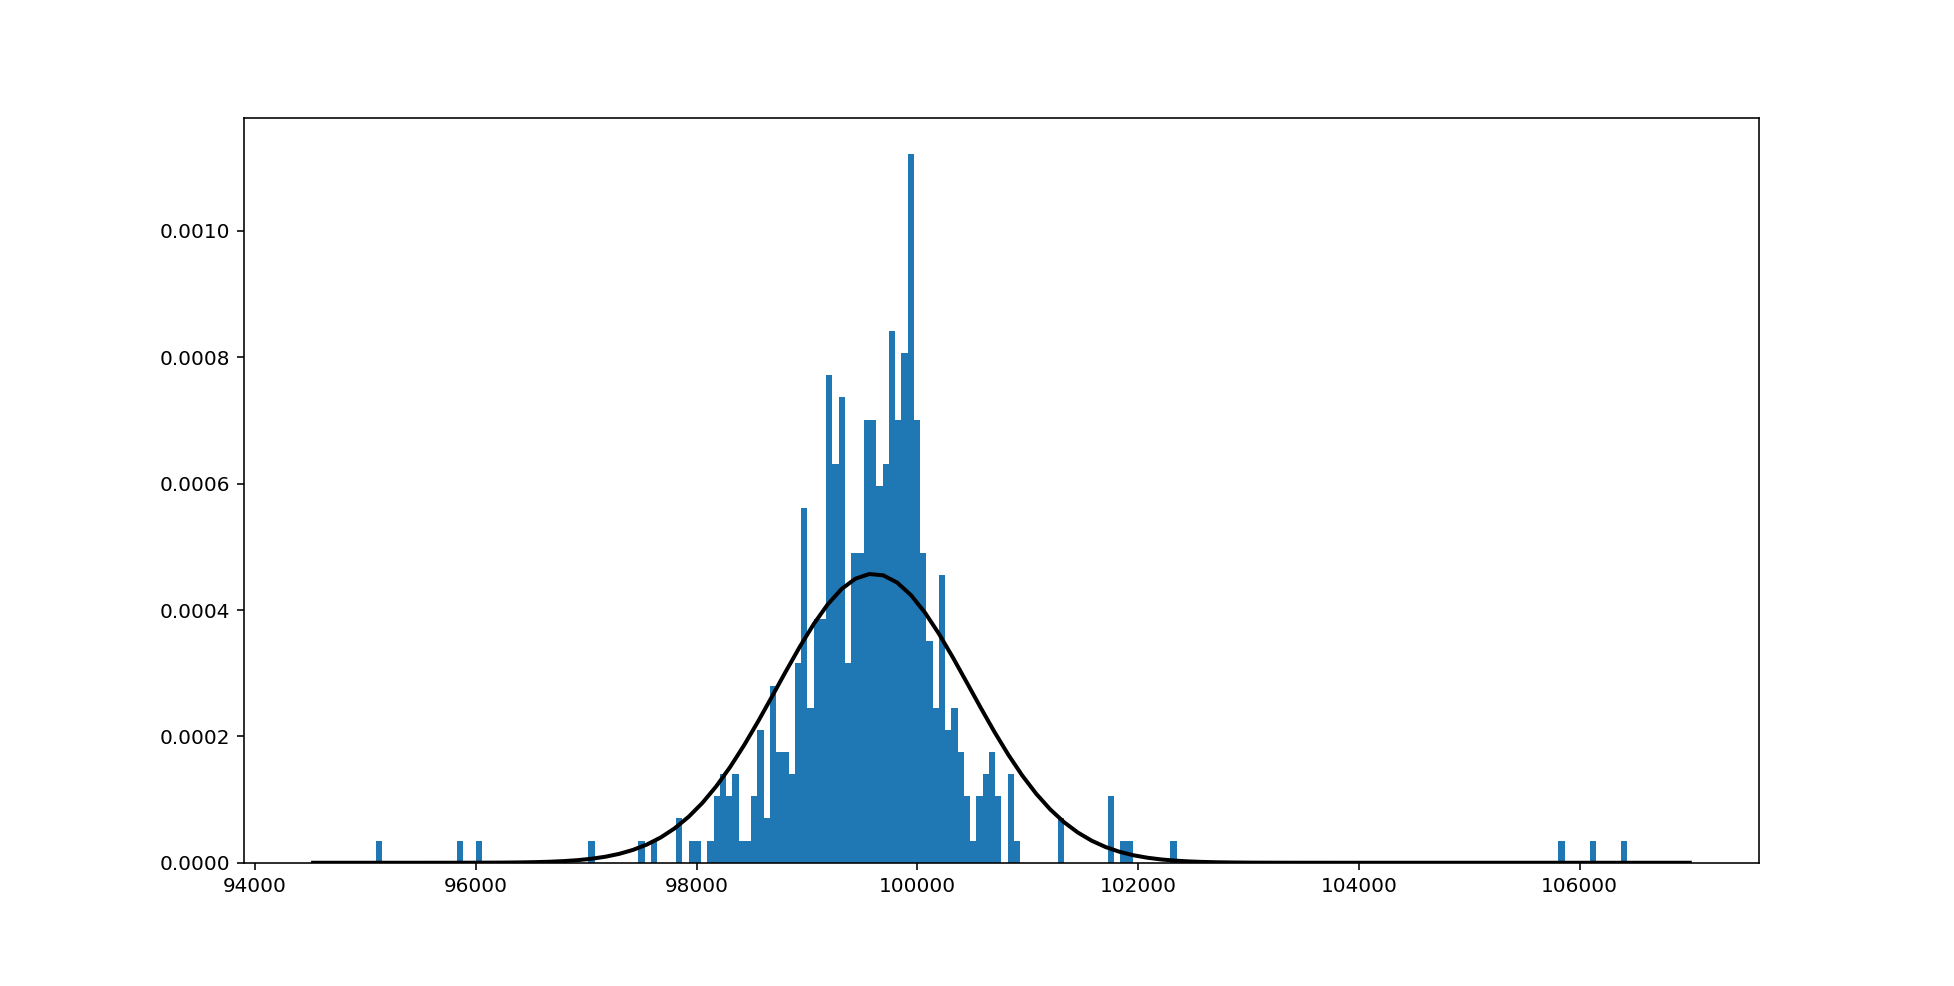

In [49]:
profit = pd.read_pickle("profit.pickle")
df = pd.Series(profit)
mu, std = norm.fit(df)
# df.describe()
plt.hist(profit,density=True,bins=200)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()


In [ ]:
df = pd.read_pickle("sp500_stocks/AAPL_av.pickle")
df.index = pd.to_datetime(df.index)
df.rename(columns={ '1. open':'open',
                    '2. high':'high',
                    '3. low':'low',
                    '4. close':'close',
                    '5. adjusted close':'adjusted close',
                    '6. volume':'volume',
                    '7. dividend amount':'dividend amount',
                    '8. split coefficient':'split coefficient'}, 
                 inplace=True)

print(df)

In [ ]:
df = pd.read_pickle("sp500_stocks/AMZN_av.pickle")
df.index = pd.to_datetime(df.index)
df.rename(columns={ '1. open':'open',
                    '2. high':'high',
                    '3. low':'low',
                    '4. close':'close',
                    '5. adjusted close':'adjusted close',
                    '6. volume':'volume',
                    '7. dividend amount':'dividend amount',
                    '8. split coefficient':'split coefficient'}, 
                 inplace=True)
# ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5, colspan=1)
# ax1.xaxis_date()
# ax1.plot(df.index,df['close'])
# ax1.figure.set_size_inches(16,9)
df['close'].plot(figsize=(16, 9))
df['adjusted close'].plot()

# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
# df2 = pd.read_csv("AAPL.csv",parse_dates=['Date'], date_parser=dateparse, index_col=['Date'])
# df2['Close'].tail(3000).plot()
# df2['Adj Close'].tail(3000).plot()

plt.legend()
plt.title(label="AMZN")
# plt.show()
# print(df.tail(1200))

In [ ]:
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
# df2 = pd.read_csv("AAPL.csv",parse_dates=['Date'], date_parser=dateparse, index_col=['Date'])
# print(df2)